On commence par un modèle Naif: On prévoit à J+7(8) la valeur moyenne de l'ensemble d'entrainement.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
stations_debit = pd.read_csv("../Data/Base/Stations_Debit.csv")
liste_stations_debit = list(stations_debit["Code station"])

mesures_train_X = pd.read_csv("../Data/Base/Mesures_Train_X.csv")
mesures_train_X["Date"] = pd.to_datetime(mesures_train_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_train_Y = pd.read_csv("../Data/Base/Mesures_Train_Y.csv")
mesures_train_Y["Date"] = pd.to_datetime(mesures_train_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

train_split_X = pd.read_csv("../Data/Base/Index_CV_X.csv")
train_split_Y = pd.read_csv("../Data/Base/Index_CV_Y.csv")

mesures_test_X = pd.read_csv("../Data/Base/Mesures_Test_X.csv")
mesures_test_X["Date"] = pd.to_datetime(mesures_test_X["Date"], format = "%Y/%m/%d %H:%M:%S")
mesures_test_Y = pd.read_csv("../Data/Base/Mesures_Test_Y.csv")
mesures_test_Y["Date"] = pd.to_datetime(mesures_test_Y["Date"], format = "%Y/%m/%d %H:%M:%S")

In [4]:
%run Eval_fcts.py
%run Standardize_fcts.py

## Score de Validation croisée.

In [25]:
cv_scores_RMSE_standard = pd.DataFrame({"Code station": liste_stations_debit})
cv_scores_MAE_standard = pd.DataFrame({"Code station": liste_stations_debit})
cv_scores_R2_standard = pd.DataFrame({"Code station": liste_stations_debit})
    
cv_scores_RMSE = pd.DataFrame({"Code station": liste_stations_debit})
cv_scores_MAE = pd.DataFrame({"Code station": liste_stations_debit})
cv_scores_R2 = pd.DataFrame({"Code station": liste_stations_debit})

for curr_split in tqdm(range(9)):
    
    curr_train_X = mesures_train_X[train_split_X["Train_" + str(curr_split)]]
    curr_train_X_mean = curr_train_X[liste_stations_debit].mean()
    curr_train_X_std = curr_train_X[liste_stations_debit].std()
    curr_test_X = mesures_train_X[train_split_X["Test_" + str(curr_split)]]
    curr_test_Y = mesures_train_Y[train_split_Y["Test_" + str(curr_split)]]
    liste_dates = curr_test_Y["Date"]
    
    predictions_Y = pd.DataFrame({"Date": list(liste_dates)})
    predictions_Y[liste_stations_debit] = curr_train_X_mean[liste_stations_debit]
    
    curr_test_Y_standard = fct_Standardize(curr_test_Y,
                                             curr_train_X_mean, curr_train_X_std,
                                             liste_stations_debit)
    curr_test_Y_standard["Date"] = curr_test_Y["Date"]
    predictions_Y_standard = fct_Standardize(predictions_Y,
                                             curr_train_X_mean, curr_train_X_std,
                                             liste_stations_debit)
    predictions_Y_standard["Date"] = predictions_Y["Date"]

    # Scores
    curr_scores_RMSE = fct_RMSE(curr_test_Y, predictions_Y, liste_stations_debit)
    cv_scores_RMSE["Split_" + str(curr_split)] = curr_scores_RMSE["RMSE"]
    curr_scores_MAE = fct_MAE(curr_test_Y, predictions_Y, liste_stations_debit)
    cv_scores_MAE["Split_" + str(curr_split)] = curr_scores_MAE["MAE"]
    curr_scores_R2 = fct_R2(curr_test_Y, predictions_Y, liste_stations_debit)
    cv_scores_R2["Split_" + str(curr_split)] = curr_scores_R2["R2"]
    # Scores standards
    curr_RMSE = fct_RMSE(curr_test_Y_standard, predictions_Y_standard, liste_stations_debit)
    cv_scores_RMSE_standard["Split_" + str(curr_split)] = curr_RMSE["RMSE"]
    curr_MAE = fct_MAE(curr_test_Y_standard, predictions_Y_standard, liste_stations_debit)
    cv_scores_MAE_standard["Split_" + str(curr_split)] = curr_MAE["MAE"]
    curr_R2 = fct_R2(curr_test_Y_standard, predictions_Y_standard, liste_stations_debit)
    cv_scores_R2_standard["Split_" + str(curr_split)] = curr_R2["R2"]

100%|██████████| 9/9 [00:00<00:00, 19.81it/s]


In [37]:
cv_moyen_RMSE_standard = []
cv_moyen_MAE_standard = []
cv_moyen_R2_standard = []
    
cv_moyen_RMSE = []
cv_moyen_MAE = []
cv_moyen_R2 = []

for code in liste_stations_debit:
    score_RMSE = np.mean(cv_scores_RMSE_standard[cv_scores_RMSE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_RMSE_standard.append(score_RMSE)
    score_MAE = np.mean(cv_scores_MAE_standard[cv_scores_MAE_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_MAE_standard.append(score_MAE)
    score_R2 = np.mean(cv_scores_R2_standard[cv_scores_R2_standard["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_R2_standard.append(score_R2)
    score_RMSE = np.mean(cv_scores_RMSE[cv_scores_RMSE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_RMSE.append(score_RMSE)
    score_MAE = np.mean(cv_scores_MAE[cv_scores_MAE["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_MAE.append(score_MAE)
    score_R2 = np.mean(cv_scores_R2[cv_scores_R2["Code station"] == code][["Split_" + str(i) for i in range(9)]].iloc[0,:])
    cv_moyen_R2.append(score_R2)

cv_scores_RMSE_standard["Moyenne"] = cv_moyen_RMSE_standard
cv_scores_RMSE_standard.to_csv("../Data/Moyenne/CV_RMSE_standard.csv",
                          index=False)
cv_scores_MAE_standard["Moyenne"] = cv_moyen_MAE_standard
cv_scores_MAE_standard.to_csv("../Data/Moyenne/CV_MAE_standard.csv",
                          index=False)
cv_scores_R2_standard["Moyenne"] = cv_moyen_R2_standard
cv_scores_R2_standard.to_csv("../Data/Moyenne/CV_R2_standard.csv",
                          index=False)
cv_scores_RMSE["Moyenne"] = cv_moyen_RMSE
cv_scores_RMSE.to_csv("../Data/Moyenne/CV_RMSE.csv",
                          index=False)
cv_scores_MAE["Moyenne"] = cv_moyen_MAE
cv_scores_MAE.to_csv("../Data/Moyenne/CV_MAE.csv",
                          index=False)
cv_scores_R2["Moyenne"] = cv_moyen_R2
cv_scores_R2.to_csv("../Data/Moyenne/CV_R2.csv",
                          index=False)

<AxesSubplot:ylabel='Density'>

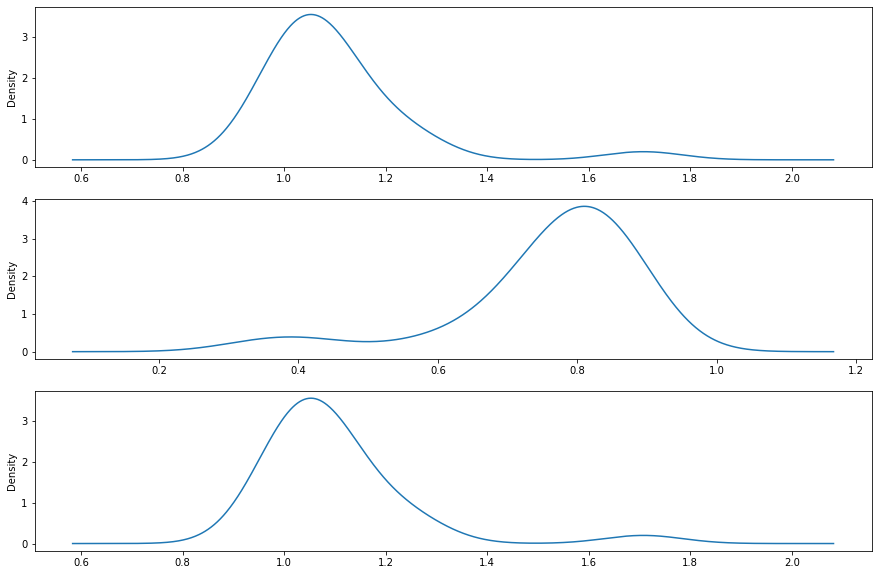

In [38]:
fig, axs = plt.subplots(3, 1, figsize = (15,10))
cv_scores_RMSE_standard["Moyenne"].plot.density(ax = axs[0])
cv_scores_MAE_standard["Moyenne"].plot.density(ax = axs[1])
cv_scores_RMSE_standard["Moyenne"].plot.density(ax = axs[2])

### Scores standards moyens

In [39]:
cv_moyen = pd.read_csv("../Data/Moyenne/CV_RMSE_standard.csv")["Moyenne"]
cv_moyen.mean()

1.0998076694909593

In [40]:
cv_moyen = pd.read_csv("../Data/Moyenne/CV_MAE_standard.csv")["Moyenne"]
cv_moyen.mean()

0.7595516336611262

In [41]:
cv_moyen = pd.read_csv("../Data/Moyenne/CV_R2_standard.csv")["Moyenne"]
cv_moyen.mean()

0.0

# Score sur l'ensemble de test

In [42]:
liste_dates = mesures_test_Y["Date"]
mesures_train_X_mean = mesures_train_X[liste_stations_debit].mean()
mesures_train_X_std = mesures_train_X[liste_stations_debit].std()

predictions_test_Y = pd.DataFrame({"Date": list(liste_dates)})
predictions_test_Y[liste_stations_debit] = mesures_train_X_mean[liste_stations_debit]

mesures_test_Y_standard = fct_Standardize(mesures_test_Y,
                                          mesures_train_X_mean, mesures_train_X_std,
                                             liste_stations_debit)
mesures_test_Y_standard["Date"] = mesures_test_Y["Date"]
predictions_test_Y_standard = fct_Standardize(predictions_test_Y,
                                             mesures_train_X_mean, mesures_train_X_std,
                                             liste_stations_debit)
predictions_test_Y_standard["Date"] = predictions_test_Y["Date"]

In [43]:
scores_RMSE = fct_RMSE(mesures_test_Y, predictions_test_Y, liste_stations_debit)
scores_MAE = fct_MAE(mesures_test_Y, predictions_test_Y, liste_stations_debit)
scores_R2 = fct_R2(mesures_test_Y, predictions_test_Y, liste_stations_debit)

test_scores = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_RMSE["RMSE"],
                            "MAE": scores_MAE["MAE"],
                            "R2": scores_R2["R2"]})
test_scores.to_csv("../Data/Moyenne/Test_scores.csv",
                   index=False)
test_scores

,Code station,RMSE,MAE,R2
0,O0200020,30.798595,24.770528,5.322536e-32
1,O2620010,152.585360,101.354800,3.469562e-32
2,O6140010,299.123010,202.573870,1.444511e-31
3,O9000010,479.406778,310.435810,5.623569e-32
4,K0030020,3.710498,1.128392,0.000000e+00
5,K0100020,5.891885,3.053838,2.272437e-32
6,K0260020,16.859221,7.952374,1.110160e-32
7,K0550010,35.593859,19.934511,8.966290e-32
8,K0690010,47.794692,28.769635,2.210147e-32
9,K0910050,50.847543,35.140009,0.000000e+00


In [45]:
scores_RMSE_standard = fct_RMSE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
scores_MAE_standard = fct_MAE(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)
scores_R2_standard = fct_R2(mesures_test_Y_standard, predictions_test_Y_standard, liste_stations_debit)

test_scores_standard = pd.DataFrame({"Code station": liste_stations_debit,
                            "RMSE": scores_RMSE_standard["RMSE"],
                            "MAE": scores_MAE_standard["MAE"],
                            "R2": scores_R2_standard["R2"]})
test_scores_standard.to_csv("../Data/Moyenne/Test_scores_standard.csv",
                   index=False)
test_scores_standard

,Code station,RMSE,MAE,R2
0,O0200020,0.663453,0.533599,0.0
1,O2620010,0.769801,0.511340,0.0
2,O6140010,0.909075,0.615649,0.0
3,O9000010,0.985997,0.638474,0.0
4,K0030020,0.605047,0.184000,0.0
5,K0100020,0.625742,0.324330,0.0
6,K0260020,0.910105,0.429290,0.0
7,K0550010,0.976982,0.547164,0.0
8,K0690010,1.068358,0.643090,0.0
9,K0910050,0.880591,0.608564,0.0


In [46]:
test_scores_standard[["RMSE", "MAE", "R2"]].mean()

RMSE    0.837216
MAE     0.621260
R2      0.000000
dtype: float64

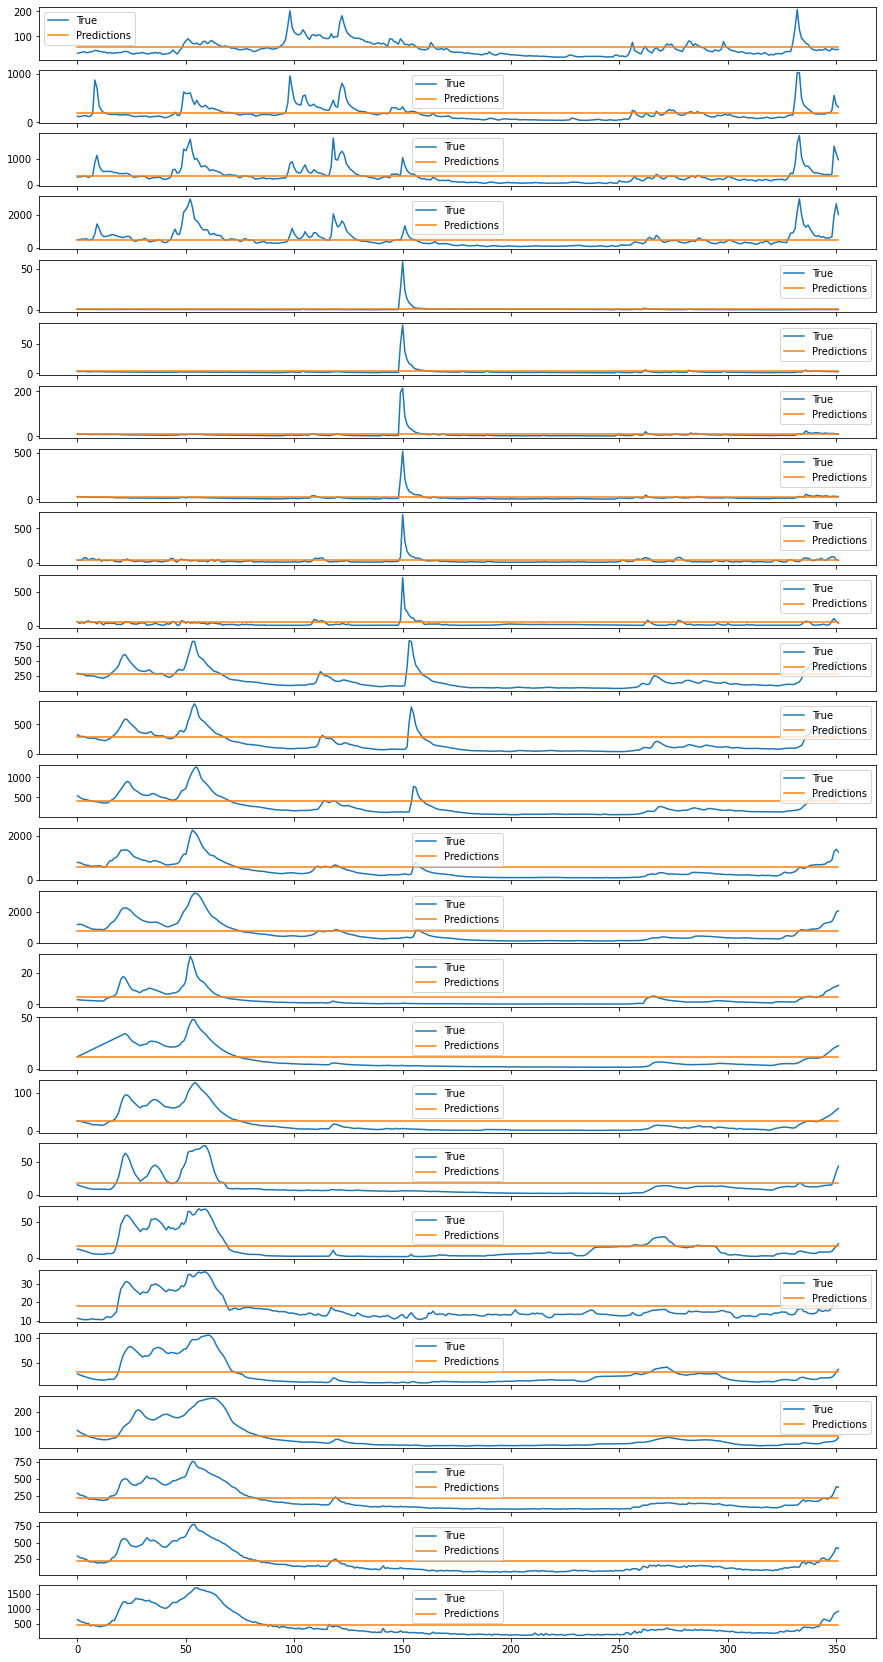

In [50]:
n_stations = len(liste_stations_debit)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations_debit[i]
    axs[i].plot(mesures_test_Y[code], label = "True")
    axs[i].plot(predictions_test_Y[code], label = "Predictions")
    axs[i].legend()

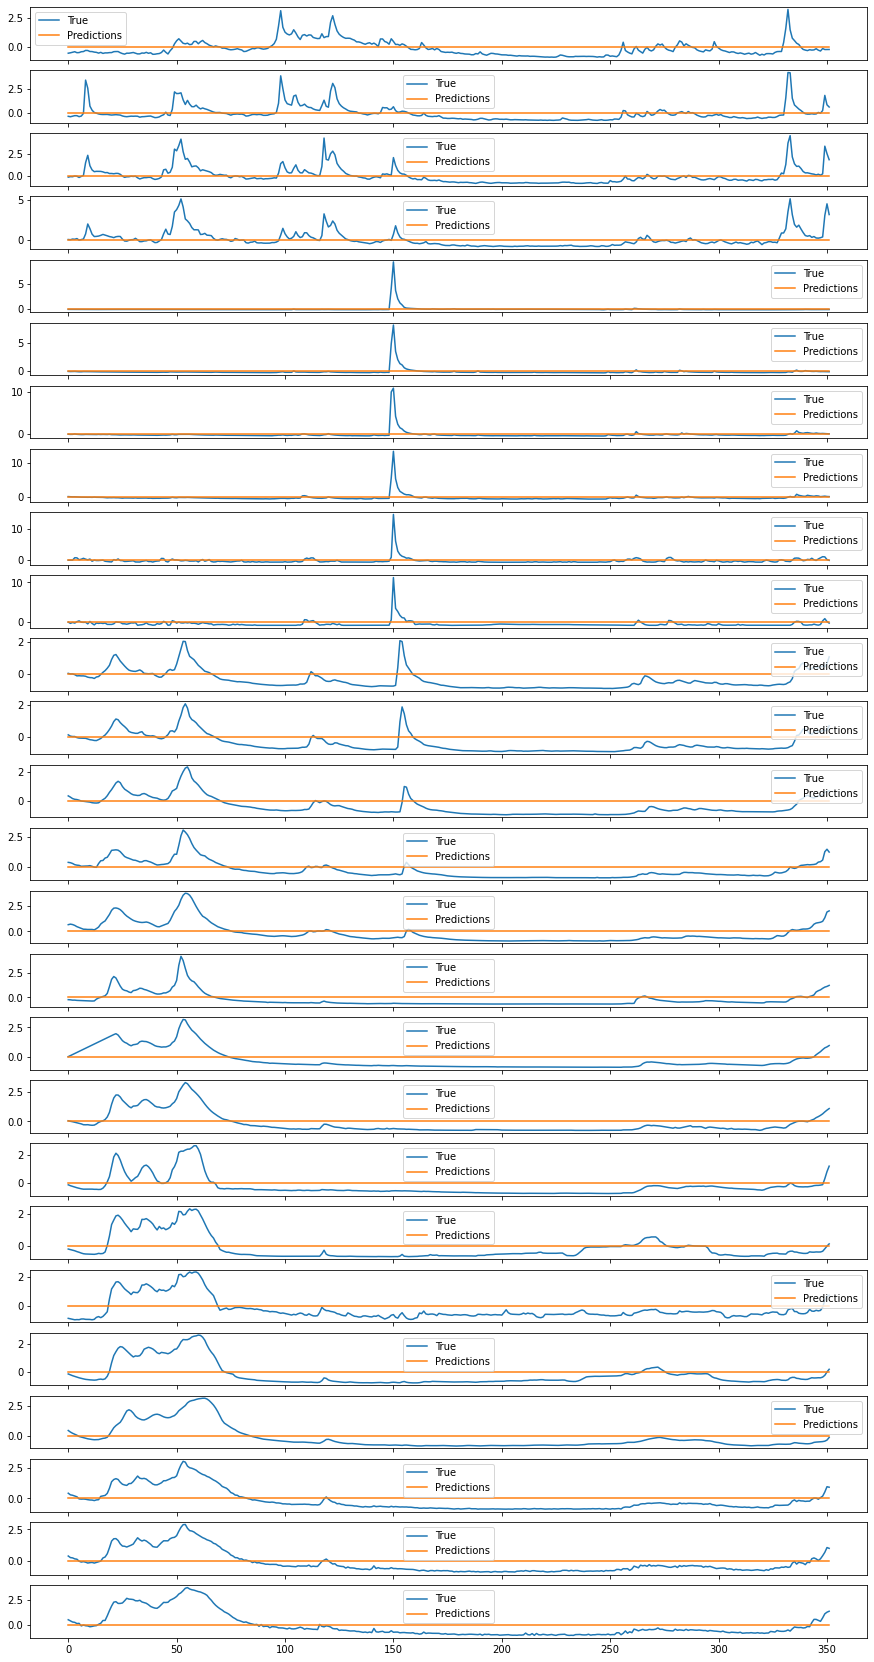

In [51]:
n_stations = len(liste_stations_debit)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations_debit[i]
    axs[i].plot(mesures_test_Y_standard[code], label = "True")
    axs[i].plot(predictions_test_Y_standard[code], label = "Predictions")
    axs[i].legend()

In [16]:
test_scores_standard[["RMSE", "MAE", "R2"]].mean()

RMSE    0.705497
MAE     0.317238
R2      0.990315
dtype: float64

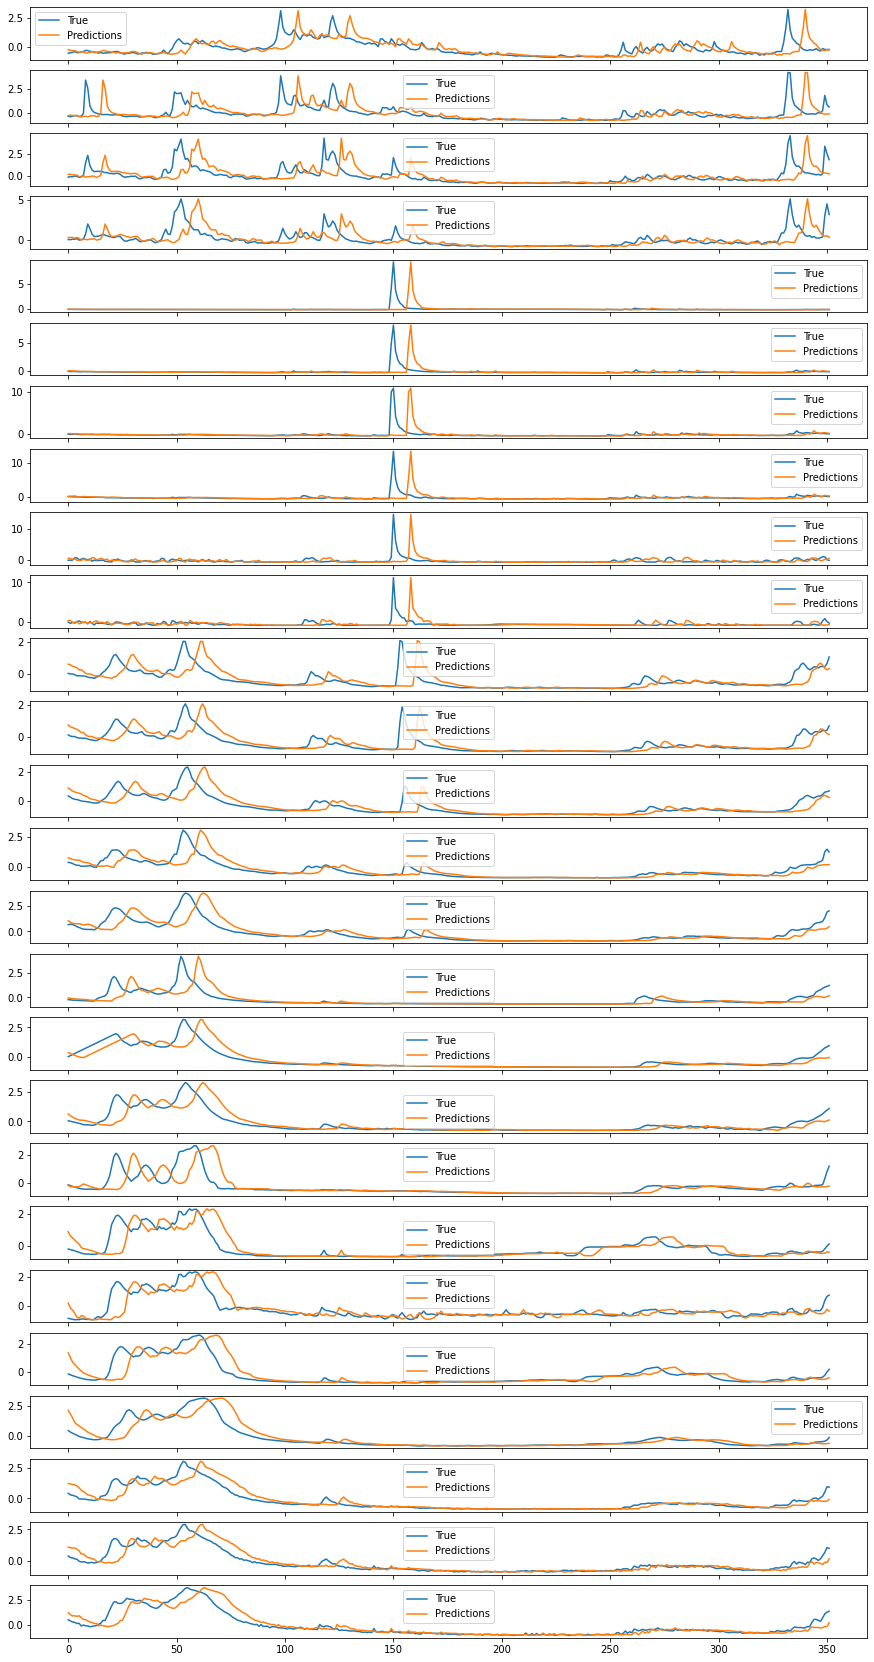

In [17]:
n_stations = len(liste_stations)
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = liste_stations[i]
    axs[i].plot(mesures_test_Y_standard[code], label = "True")
    axs[i].plot(predictions_test_Y_standard[code], label = "Predictions")
    axs[i].legend()